# IBM Data Science Specialization - Final Project

This is the notebook for Darvesh Gorhe's capstone project for the IBM Data Specialization on Coursera

## Table of Contents
* [Introduction](#introduction)
     - [Problem Outline](#problem-outline) 
     - [Data Used](#data-used)
* [Collecting Data](#collecting-data)
    - [Extracting Neighborhood Data](#extracting-neighborhood-data)
    - [Geocoding Neighborhoods](#geocoding-neighborhoods)
    - [Getting Venues in Neighborhoods](#getting-venues)
    - [Filtering Extraneous Venues](#filtering-extraneous-venues)
* [Methodology](#methodology)
    - [Total Coffee Shops per Neighborhood](#total-shops)
    - [Unique Coffee Shops per Neighborhood](#unique-shops)
    - [Top 10 Neighborhoods by Total Number of Coffee Shops](#top10-total)
    - [Top 10 Neighborhoods by Unique Number of Coffee Shops](#top10-unique)
    - [K-Means Clustering](#clustering)
* [Results & Discussion](#results-and-discussion)
* [Conclusion](#conclusion)

# A. Introduction <a name="introduction"></a>

## Problem Outline <a name="problem-outline"></a>
For this project, I wanted to compare the coffee scene between the neighborhoods in Seattle. The purpose of this is to understand the distribution of coffee shops in the various neighborhoods to see which neighborhoods have high competition among coffee shops and where to open a new coffee shop. 

The data presented will be focused on two main audiences: those wanting to open a coffee shop as a small business and coffee chains (e.g. Starbucks, Peet's Tea & Coffee, etc). I picked these two audiences because the same data and analysis would yield different conclusions for each audience. For a large chain, opening a new storefront in an area with many coffee shops could mean that they are competing with their own neighboring storefronts. However, for someone wanting to start a small business, an already dense location would be more optimal since people already go there for coffee. 

## Data Used<a name="data-used"></a>
I will be using the following data for my analysis:
* Absolute number of coffee shops 
* The number of coffee shops per neighborhood
* The number of unique coffee shops per neighborhood
* Latitude and Longitude of each coffee shop

# Collecting Data <a name="collecting-data"></a>

## Extracting Neighborhood Data <a name="extracting-neighborhood-data"></a>

Let's use a geojson file to extract the neighborhood names we're going to use. The geojson was more inclusive than the Wikipedia page for neighborhoods in Seattle, so I'm using the geojson file's neighborhoods. The original file can be found <a href="https://github.com/seattleio/seattle-boundaries-data/blob/master/data/neighborhoods.geojson">here</a>.

In [1]:
import json

with open ('seattle.json', 'r') as f:
    seattle_geo = json.load(f)
    
seattle_neighborhoods = []    

for n in range(0,len(seattle_geo['features'])):
    seattle_neighborhoods.append(seattle_geo['features'][n]['properties']['name'])

## Geocoding Neighborhoods <a name="geocoding-neighborhoods"></a>

Now that we have the neighborhoods and their boundaries, we need to get their location in latitude and longitude coordinates. To do so, we're going to use a package called geopy to geocode the names of the neighborhoods into their respective latitude and longitude coordinates. 

In [3]:
# Geocoding Neighborhoods
import pandas as pd
import sys
import geopy
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

# Lengthening the timeout to avoid unnecessary GeocoderTimedOut errors
geopy.geocoders.options.default_timeout = 7

geolocator = Nominatim(user_agent='coursera_project_final')

# Creating empty dataframe    
df_cols = ['Neighborhood', 'Latitude', 'Longitude']
df_coordinates = pd.DataFrame(columns=df_cols)
exceptions = []

# Progress bar
print('----------')
print('Progress')
print('----------')
geo_count = 0

# Main loop for each neighborhood
for hood in seattle_neighborhoods:
    try:
        location = geolocator.geocode(hood+", Seattle")
    except GeocoderTimedOut as e:
        print("Could not retrieve location for %s, Seattle \n"%(hood))
        exceptions.append(hood)

    if location != None:
        lat = location.latitude
        lon = location.longitude

    df_coordinates = df_coordinates.append({"Neighborhood": hood,
                                       "Latitude": lat,
                                       "Longitude": lon}, 
                                       ignore_index=True)
    if geo_count % 17 == 0:
        sys.stdout.write('|')
    geo_count += 1  

try_count = 1

# Fail safe in case there are locations that couldn't be geocoded the first time
while (len(exceptions) != 0) and (try_count <= 10):   
    for e in exceptions:
        try:
            location = geolocator.geocode(e+", Seattle")
        except GeocoderTimedOut:
            print("Could not retrieve location for %s, Seattle"%(e))

        if location != None:
            lat = location.latitude
            lon = location.longitude  

        df_coordinates.loc[df_coordinates['Neighborhood'] == e, 'Latitude'] = lat
        df_coordinates.loc[df_coordinates['Neighborhood'] == e, 'Longitude'] = lon
    try_count += 1

----------
Progress
----------
|||||Could not retrieve location for West Wellington, Seattle 

Could not retrieve location for Wedge, Seattle 

||||||

## Getting Venues in Neighborhoods <a name="getting-venues"></a>

Here I'm extracting my Client ID and Client Secret token for my Foursquare account. 

In [11]:
from configparser import ConfigParser

config = ConfigParser()
config.read('config.cfg')

CLIENT_ID = config.get('client_tokens', 'client_id')
CLIENT_SECRET = config.get('client_tokens', 'client_secret')

I'm making a request to the Foursquare API to get me all coffee shops within a 1500 meter radius of each neighborhood center. I used 1500 meters since the smallest neighborhoods had an area such that if it were circular the radius would be roughly 1500 meters.

In [12]:
import requests

VERSION = '20200326'
category_id = '4bf58dd8d48988d1e0931735' #coffee shop category id
radius = 1500
LIMIT = 1000

coffee_list = []
print('----------')
print('Progress')
print('----------')
count=0

for index, row in df_coordinates.iterrows():
    
    url = 'https://api.foursquare.com/v2/venues/explore?&query=coffee&client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'\
    .format(CLIENT_ID, 
            CLIENT_SECRET, 
            row['Latitude'], 
            row['Longitude'], 
            VERSION, 
            category_id, 
            radius, 
            LIMIT)

    results = requests.get(url).json()['response']['groups'][0]['items']

    coffee_list.append([(
        row['Neighborhood'], 
        row['Latitude'],
        row['Longitude'],
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results])
    
    if count % 17 == 0:
        sys.stdout.write('|')
    count += 1 

print('\n\nDone with API calls')
    
coffee_shops = pd.DataFrame([item for coffee_shop in coffee_list for item in coffee_shop])
coffee_shops.columns = ['Neighborhood',
                       'Neighborhood Latitude',
                       'Neighborhood Longitude',
                       'Venue',
                       'Venue Latitude',
                       'Venue Longitude',
                       'Venue Category']

----------
Progress
----------
|||||||||||

Done with API calls


## Filtering Extraneous Venues <a name="filtering-extraneous-venues"></a>

Upon initial inspection, some locations had been geocoded incorrectly. This code remedies that by checking whether the latitudes and longitudes of each coffee shops are within the Seattle area. I'm also excluding the neighborhood of Skykomish since it is well outside of the Greater Seattle Area. This will insure that there are no outlier coffee shops included in our analyses.

In [57]:
# Removing extraneous latitude and longitude values
lats_to_drop = coffee_shops.index[coffee_shops['Venue Latitude'] < 45].tolist()

lons_to_drop = coffee_shops.index[coffee_shops['Venue Longitude'] > -121].tolist()

coffee_shops.drop(index=lons_to_drop, axis=0, inplace=True)
coffee_shops.drop(index=lats_to_drop, axis=0, inplace=True)

In [40]:
# Manually removing Skykomish since it is an outlier

skykomish = coffee_shops.index[coffee_shops['Neighborhood'] == 'Skykomish'].tolist()
coffee_shops.drop(index=skykomish, axis=0, inplace=True)

In [48]:
coffee_shops.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue_X,Venue_Y,labels
0,Loyal Heights,47.688709,-122.392907,The Dane,47.686950,-122.376539,Beer Bar,-2.643134e+06,1.376679e+07,0
1,Loyal Heights,47.688709,-122.392907,Mabel Coffee,47.679650,-122.387924,Coffee Shop,-2.642854e+06,1.376808e+07,0
2,Loyal Heights,47.688709,-122.392907,Starbucks,47.690642,-122.376223,Coffee Shop,-2.642897e+06,1.376639e+07,0
3,Loyal Heights,47.688709,-122.392907,Jibe Espresso Bar,47.680613,-122.404677,Coffee Shop,-2.641618e+06,1.376878e+07,0
4,Loyal Heights,47.688709,-122.392907,Robertino's,47.686896,-122.388103,Café,-2.642332e+06,1.376734e+07,0


# Methodology <a name="methodology"></a>

## Total Coffee Shops per Neighborhood <a name="total-shops"></a>

One useful metric is the total number of shops per neighborhood. This will give us an idea of the density of coffee shops in each neighborhood. 

In [45]:
# Grouping larger dataframe by neighborhoods and counting venues
total_count = coffee_shops.groupby(['Neighborhood']).count()
total_count = total_count[['Venue']]
total_count.reset_index(inplace=True)

total_count.columns = ['name', 'Coffee Shops']

total_count.head()

,name,Coffee Shops
0,Adams,11
1,Algona,4
2,Alki,7
3,Arbor Heights,7
4,Atlantic,62


Plotting those numbers using a choropleth map we can see the spatial distribution of coffee shops by neighborhood.

In [68]:
import plotly.express as px

seattle_geo = r'./seattle.json' #GEOjson of Seattle Neighborhoods

seattle_lat = 47.6062
seattle_lon = -122.3321

fig = px.choropleth_mapbox(total_count, 
                    geojson=seattle_geo,
                    color_continuous_scale='Viridis',
                    range_color=(0,50),
                    locations='name',
                    center = {'lat':seattle_lat, 'lon':seattle_lon},
                    mapbox_style='carto-positron',
                    featureidkey='properties.name', 
                    color='Coffee Shops')

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

## Unique Coffee Shops per Neighborhood <a name="unique-shops"></a>

Another useful metric is the number of unique coffee shops per neighborhood. 

In [37]:
unique_count = coffee_shops.groupby('Neighborhood')['Venue'].nunique()
unique_count = unique_count.to_frame()
unique_count.reset_index(inplace=True)

unique_count.columns = ['name', 'Unique Coffee Shops']

Again, plotting the unique coffee shops on a choropleth map gives us a better spatial representation of this count.

In [69]:
fig_unique = px.choropleth_mapbox(unique_count, 
                    geojson=seattle_geo,
                    color_continuous_scale='Viridis',
                    range_color=(0,50),
                    locations='name',
                    center = {'lat':seattle_lat, 'lon':seattle_lon},
                    mapbox_style='carto-positron',
                    featureidkey='properties.name', 
                    color='Unique Coffee Shops')

fig_unique.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig_unique.show()

## Top 10 Neighborhoods by Total Number of Coffee Shops <a name="top10-total"></a>

What are the top 10 neighborhoods for coffee shops (by total count)?

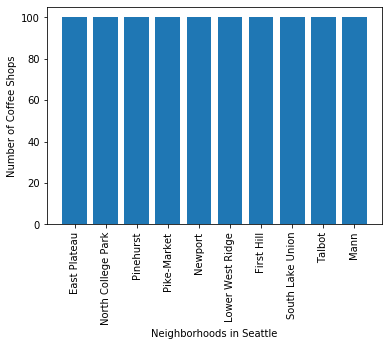

In [49]:
import matplotlib.pyplot as plt

top10 = total_count.sort_values('Coffee Shops', ascending=False)
top10 = top10.iloc[0:10,:]

fig = plt.Figure(figsize=(14,10))

plt.bar(height=top10['Coffee Shops'], x=top10['name'], align='center')
plt.xticks(rotation='vertical')
plt.xlabel('Neighborhoods in Seattle')
plt.ylabel('Number of Coffee Shops')
plt.show()

## Top 10 Neighborhoods by Number of Unique Coffee Shops <a name="top10-unique"></a>

What about the top 10 neighborhoods by unique count?

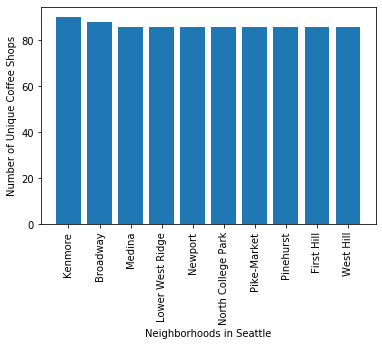

In [50]:
unique_count.reset_index()

top10_unique = unique_count.sort_values('Unique Coffee Shops', ascending=False)
top10_unique = top10_unique.iloc[0:10]

top10_unique = top10_unique.reset_index()


fig = plt.Figure(figsize=(14,10))
plt.bar(height=top10_unique['Unique Coffee Shops'], x=top10_unique['name'], align='center')

plt.xticks(rotation='vertical')
plt.xlabel('Neighborhoods in Seattle')
plt.ylabel('Number of Unique Coffee Shops')
plt.show()

This finding is somewhat interesting. Only Pinehurst, Broadway, Medina, and First Hill are in the top 10 for both highest total and most number of unique coffee shops. This suggests that quantity is not necessarily indicative of variety.

## K-means Clustering <a name="clustering"></a>

I'm defining functions to convert latitude and longitude coordinates into cartesian coordinates. The goal of this is to map the venues to a cartesian plane, group them using K-means clustering and then convert the centers back to latitude and longitude coordinates.

In [23]:
import shapely.geometry
import pyproj
import math


# Latitude and Longitude to Cartesian
def latlon_to_xy(lat, lon):
    proj_latlon = pyproj.Proj(proj='latlong', datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

# Cartesian to Latitude and Longitude
def xy_to_latlon(x, y):
    proj_latlon = pyproj.Proj(proj='latlong', datum='WGS84')
    proj_xy = pyproj.Proj(proj='utm', zone=33, datum='WGS84')
    latlon = pyproj.transform(proj_xy, proj_latlon, x, y)
    return latlon[0], latlon[1]

Creating two lists for the horizontal axis coordinates and vertical axis coordinates respectively and adding those as columns to the coffee_shops dataframe.

In [60]:
Venue_X = []
Venue_Y = []

for lat, lon in coffee_shops[['Venue Latitude', 'Venue Longitude']].values:
    x, y = latlon_to_xy(lat, lon)
    Venue_X.append(x)
    Venue_Y.append(y)

print('Done converting latitudes and longitudes to cartesian coordinates')

try:
    coffee_shops['Venue_X'] = Venue_X
    coffee_shops['Venue_Y'] = Venue_Y
except:
    print("Something's not right")

Done converting latitudes and longitudes to cartesian coordinates


Here I'm creating many models, each with a different number of clusters to determine which cluster size to use via the elbow method. The elbow method involves plotting the number of clusters versus the intertia of each fit. The cluster number which produces the sharpest drop in intertia will be the one I use for my final model.

In [61]:
from sklearn.cluster import KMeans

inertia_for_nclusters = []
venue_xys = coffee_shops[['Venue_X', 'Venue_Y']].values

for n in range(1,15):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(venue_xys)
    inertia_for_nclusters.append(kmeans.inertia_)
    
n_clusters = list(range(1,15))
inertia_for_nclusters = [inertia/10000000000 for inertia in inertia_for_nclusters]

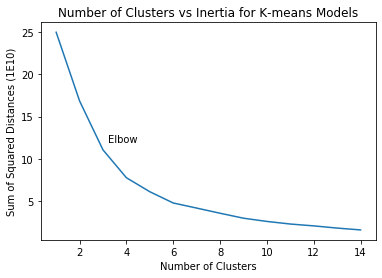

In [70]:
# Plotting inertia vs cluster number

plt.plot(n_clusters, inertia_for_nclusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (1E10)')
plt.text(x=3.2, y=12, s="Elbow")
plt.title('Number of Clusters vs Inertia for K-means Models')

plt.show()

Although it is a little ambiguous, it seems that 3 clusters produces the sharpest drop in inertia so I will use 3 clusters for my final model.

Now that we know how many clusters to use, let's make a final model with 2 clusters and fine their centers as latitude and longitude coordinates.

In [64]:
final_kmeans = KMeans(n_clusters=3, random_state=0).fit(venue_xys)

# Getting cartesian coordinates of clusters 1,2, and 3
cluster1_x = final_kmeans.cluster_centers_[0][0]
cluster1_y = final_kmeans.cluster_centers_[0][1]

cluster2_x = final_kmeans.cluster_centers_[1][0]
cluster2_y = final_kmeans.cluster_centers_[1][1]

cluster3_x = final_kmeans.cluster_centers_[2][0]
cluster3_y = final_kmeans.cluster_centers_[2][1]


# Converting the cluster centers from Cartesian to latitude and longitude coordinates
cluster1_lon, cluster1_lat = xy_to_latlon(cluster1_x, cluster1_y)
cluster2_lon, cluster2_lat = xy_to_latlon(cluster2_x, cluster2_y)
cluster3_lon, cluster3_lat = xy_to_latlon(cluster3_x, cluster3_y)

print("Coordinates of cluster 1: ", cluster1_lat, cluster1_lon)
print("Coordinates of cluster 2: ", cluster2_lat, cluster2_lon)
print("Coordinates of cluster 2: ", cluster3_lat, cluster3_lon)

Coordinates of cluster 1:  47.60729823521312 -122.32997369117916
Coordinates of cluster 2:  47.67554250176733 -122.31887377188464
Coordinates of cluster 2:  47.41253013269121 -122.23445645908285


## Map of KMeans Cluster Centers <a name='kmeans-map'></a>

In [71]:
import plotly.graph_objects as go

# Getting mapbox token from config file
config.read('mapbox_token.cfg')
mb_token = config.get('auth', 'public_token')

# Plotting all 3 cluster centers as markers
fig_centers = go.Figure(go.Scattermapbox(
        lat=[cluster1_lat, cluster2_lat, cluster3_lat],
        lon=[cluster1_lon, cluster2_lon, cluster3_lon],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=['Coffee Shop Cluster 1', 'Coffee Shop Cluster 2'],
    ))

fig_centers.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken=mb_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=47.5,
            lon=-122.1),
        pitch=0,
        zoom=8
    )
)

fig_centers.show()

In [66]:
# Adding kmeans labels as a column in coffee_shops dataframe
shop_labels = final_kmeans.labels_.tolist()
coffee_shops['labels'] = shop_labels

coffee_shops.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue_X,Venue_Y,labels
0,Loyal Heights,47.688709,-122.392907,The Dane,47.686950,-122.376539,Beer Bar,-2.643134e+06,1.376679e+07,1
1,Loyal Heights,47.688709,-122.392907,Mabel Coffee,47.679650,-122.387924,Coffee Shop,-2.642854e+06,1.376808e+07,1
2,Loyal Heights,47.688709,-122.392907,Starbucks,47.690642,-122.376223,Coffee Shop,-2.642897e+06,1.376639e+07,1
3,Loyal Heights,47.688709,-122.392907,Jibe Espresso Bar,47.680613,-122.404677,Coffee Shop,-2.641618e+06,1.376878e+07,1
4,Loyal Heights,47.688709,-122.392907,Robertino's,47.686896,-122.388103,Café,-2.642332e+06,1.376734e+07,1


In [67]:
# Showing each coffee shop based on which cluster it is a member of

px.set_mapbox_access_token(mb_token)

fig_cluster = px.scatter_mapbox(coffee_shops, 
                                lat="Venue Latitude", 
                                lon="Venue Longitude",     
                                color="labels",
                                hover_name='Venue',
                                color_continuous_scale=
                                px.colors.sequential.Jet, 
                                size_max=15, 
                                zoom=10)


fig_cluster.update_layout(hovermode='closest')

fig_cluster.show()

## D. Results & Discussion <a name="results-and-discussion"></a>

<p>From the analyses done above we can see that, as expected, the highest density of coffee shops exists toward the center of Seattle. The center of Seattle is high density not only in terms of the total number of coffee shops, but also in the number of unique coffee shops. In other words, this center has not only quantity but variety. Four neighborhoods in Seattle are in the top 10 for both total number of coffee shops and number of unique coffee shops. Geographically, there is a high concentration of coffee shops and unique ones in the center of Seattle, but quantity and variety are not always present in the same neighborhoods.</p>

<p>So what does this mean for prospective businesses? Well if a business is looking to open a unique coffee shop (i.e. a coffee shop as a small business) then they should actually find a storefront near the center of each cluster in Seattle. But why would you open a storefront in a place where there's so many existing options? It turns out that businesses selling the same kind of product mimic similar businesses in features such as location in order to maximize the probability of successfully selling a product (<a src="https://web.archive.org/web/20160221155849/http://people.bath.ac.uk/ecsjgs/Teaching/Industrial%20Organisation/Papers/Hotelling%20-%20Stability%20in%20Competition.pdf">Hotelling & Harold 1929</a>). The assumption is that consumers generally don't have a clear understanding of what they desire in a product so on average you can expect sales in a given location to be equally distributed across competitors. The implication for small businesses is that, by sheer volume and probability, customers will come if your business is competitive on other dimensions as well.</p>

<p>All that being said, the same reasoning cannot be applied to large chains like Starbucks. If a chain coffee shop opened many storefronts in a dense area they would be cutting into their own competition. If we assume that the number of other shops remains constant then each additional storefront the chain opens will be less of market share then the first storefront. Even that would be an ideal case since we would have to assume that the two sets of customers are disjoint. So what does this mean for the large chains? One takeaway is to not open a storefront near the cluster centers shown in the map of the K-means cluster centers.</p>

## E. Conclusion <a name="conclusion"></a>

<p>The final decision of where to open a storefront will depend on the constraints of the business or individual planning to open a coffee shop. The main factor that wasn't considered in this analysis was the price of renting a storefront in each of these neighborhoods. That data would provide clarity as to which of the neighborhoods among those most populated and diverse in coffee shops. Another important factor to consider is the preferences of coffee drinkers in Seattle and the hours to keep the storefront open. Retrieving the hours for each venue is a premium API call on Foursquare and since I needed to spend a lot of calls to create this notebook, I didn't include the hours of each coffee shop. Those extra pieces of data, hours and retail storefront costs, would improve the analysis provided.</p>